In [1]:

import numpy as np
import pandas as pd
%matplotlib inline
import glob
import keras
from functools import reduce


Using TensorFlow backend.


In [2]:
path = r'/Users/mahnooshsadeghi/Desktop/PTSD/PTSD Data/Kalman Imputed Data' # use your path
all_files = glob.glob(path + "/*.csv")

In [3]:
participant=1
li=[]

In [4]:
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    l=df.index[df['ptsd_moment'] == 'STRESSMOMENT'].tolist()
    for i in l:
        df.ptsd_moment[i-30: i+30]= 'STRESSMOMENT'
    #df['participant']=participant
    df['windowno']= -1
    j=0
    k=1
    while j<len(df.index)-59:
        df['windowno'][j:j+60]=k
        j=j+60
        k=k+1
    df1=df.dropna(axis=0, subset=['hr'])
    df1 = df1.reset_index(drop=True)
    count =  df1.groupby('windowno', as_index=False)['hr'].size()
    for i in df1.windowno:
        if count[i]<40:
            df1=df1[df1.windowno != i ]
    df1.loc[df1.ptsd_moment != 'STRESSMOMENT', 'ptsd_moment'] = 0
    df1.loc[df1.ptsd_moment == 'STRESSMOMENT', 'ptsd_moment'] = 1
    hrmean=df1.groupby('windowno', as_index=False)['hr'].mean()
    hrmean=hrmean.rename(columns={"hr": "hrmean"})
    hrsd=df1.groupby('windowno').agg(np.std,ddof=0)['hr']
    hrsd=pd.DataFrame(hrsd)
    hrsd=hrsd.rename(columns={"hr": "hrsd"})
    stress=df1.groupby('windowno', as_index=False)['ptsd_moment'].max()
    hrmin=df1.groupby('windowno', as_index=False)['hr'].min()
    hrmin=hrmin.rename(columns={"hr": "hrmin"})
    hrmax=df1.groupby('windowno', as_index=False)['hr'].max()
    hrmax=hrmax.rename(columns={"hr": "hrmax"})
    linaccx=df1.groupby('windowno', as_index=False)['linear_accel_x'].mean()
    linaccy=df1.groupby('windowno', as_index=False)['linear_accel_y'].mean()
    linaccz=df1.groupby('windowno', as_index=False)['linear_accel_z'].mean()
    acc_x=df1.groupby('windowno', as_index=False)['acc_x'].mean()
    acc_y=df1.groupby('windowno', as_index=False)['acc_y'].mean()
    acc_z=df1.groupby('windowno', as_index=False)['acc_z'].mean()
    data=reduce(lambda x,y: pd.merge(x,y, on='windowno', how='outer'),
       [hrmean,hrmin,hrmax,hrsd,linaccx,linaccy,linaccz,acc_x,acc_y,acc_z,stress])
    data['participant']=participant
    participant=participant+1
    li.append(data)

frame = pd.concat(li, axis=0, ignore_index=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.

KeyboardInterrupt: 

In [6]:
frame.ptsd_moment.value_counts()


0.0    6257
1.0     310
Name: ptsd_moment, dtype: int64

In [10]:
frame.participant.value_counts()


In [18]:
frame['hrrange']= frame['hrmax']-frame['hrmin']

In [26]:
frame ['linacc']= (frame['linear_accel_x']**2+frame['linear_accel_y']**2+frame['linear_accel_z']**2)**0.5

In [32]:
export_csv = frame.to_csv (r'/Users/mahnooshsadeghi/Desktop/PTSD/PTSD Data/export_dataframe.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path



In [35]:
# Divide by class
frame0 = frame[frame['ptsd_moment'] ==0]
frame1 = frame[frame['ptsd_moment'] == 1]


In [45]:
count_class_0, count_class_1 = frame.ptsd_moment.value_counts()

In [46]:
count_class_1

310

In [71]:
frame0under = frame0.sample(3*count_class_1)
frameunder = pd.concat([frame0under, frame1], axis=0)

In [110]:
X= frameunder[['acc_x','acc_y','acc_z','linear_accel_x','linear_accel_y',
      'linear_accel_z','linacc','hrmax', 'hrmean','hrmin','hrrange','hrsd']]
#X= frameunder[['linacc','hrmax', 'hrmean','hrmin','hrrange','hrsd']]
y= frameunder[['ptsd_moment']]

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [112]:
import xgboost

In [113]:
from xgboost import XGBClassifier

In [114]:
clf= XGBClassifier ()

In [115]:
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [116]:
from sklearn import metrics


predictions=clf.predict(X_test)

print(metrics.confusion_matrix(y_test,predictions))

[[267  12]
 [ 81  12]]


In [118]:
Confusion = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), 
                         index=['NO PTSD','PTSD'], 
                         columns=['NO PTSD','PTSD'])
Confusion

accuracy = accuracy_score(y_test, predictions)
accuracy

0.75

In [119]:
from sklearn.metrics import auc

fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=2)


In [108]:
y_preds = clf.predict_proba(X_test)

# take the second column because the classifier outputs scores for
# the 0 class as well
preds = y_preds[:,1]
import matplotlib.pyplot as plt


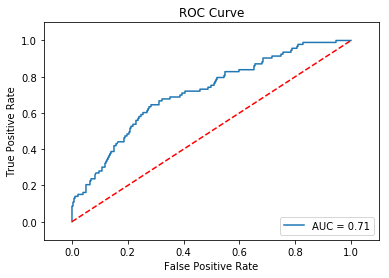

In [120]:
# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)

# clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

In [98]:
frame

,acc_x,acc_y,acc_z,hrmax,hrmean,hrmin,hrsd,linear_accel_x,linear_accel_y,linear_accel_z,participant,ptsd_moment,windowno,hrrange,linacc
0,1.073281,1.827534,8.908785,86.00,72.466667,67.0,4.667143,0.296569,0.330032,0.173684,1,0.0,365,19.00,0.476488
1,0.475648,0.826718,9.862674,73.00,69.491667,68.0,1.406804,0.150159,0.056768,0.128010,1,0.0,366,5.00,0.205322
2,0.470141,0.190499,9.847990,69.00,67.283333,66.0,0.866587,0.162381,0.064864,0.070411,1,0.0,367,3.00,0.188501
3,0.520579,0.345723,9.815788,71.00,68.533333,67.0,0.939267,0.158941,0.058659,0.046467,1,0.0,368,4.00,0.175676
4,2.084512,4.394996,6.980574,81.00,72.916667,68.0,3.448148,0.336181,0.566569,0.464983,1,0.0,369,13.00,0.806367
5,2.182275,1.062108,9.600150,74.00,69.658333,67.0,1.575103,0.143231,0.093801,0.088796,1,0.0,370,7.00,0.192869
6,2.204741,1.467646,9.588778,69.00,67.125000,65.0,0.997508,0.128209,0.086185,0.098142,1,0.0,371,4.00,0.183022
7,2.109651,2.173975,9.521222,74.00,68.754167,66.0,2.349420,0.121309,0.089109,0.115471,1,0.0,372,8.00,0.189710
8,1.031302,1.290634,9.500591,73.00,67.816667,65.0,2.315647,0.160458,0.085112,0.093121,1,0.0,373,8.00,0.204114
9,1.491759,4.069915,7.749347,78.50,73.217391,67.0,3.024831,0.354754,0.396288,0.426246,1,0.0,374,11.50,0.681601
